# Inferential Statistics III - Bayesian

### Loading the data and performing an initial view

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma
# there has been some incompatibilty between theano and numpy, if you encounter
# an error with the latest packages from anaconda, then the included
# package-list-txt should allow you to create a conda environment with compatible
# packages.

In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

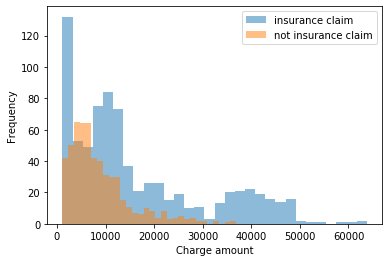

In [5]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

### Initial parameter estimation

In [6]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

In [7]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

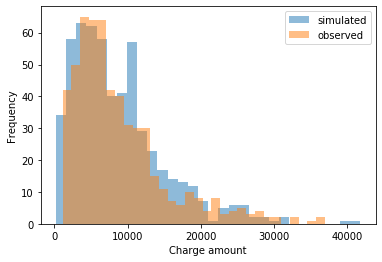

In [8]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

### Creating a PyMC3 model

In [9]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

In [10]:
with pm.Model() as model:
    alpha_ = pm.Exponential("alpha", 1/alpha_est)
    rate_ = pm.Exponential("beta", 1/rate_est)
    
    gamma_ = pm.Gamma("gamma", alpha=alpha_, beta=rate_, observed=no_insurance)
    step = pm.Metropolis([alpha_, rate_])
    trace = pm.sample(draws=10000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:15<00:00, 2747.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [11]:
# get samples
alpha_samples = trace['alpha']
beta_samples = trace['beta']

# get 95% interval
alpha_95 = np.percentile(alpha_samples, [2.5, 97.5])
beta_95 = np.percentile(beta_samples, [2.5, 97.5])

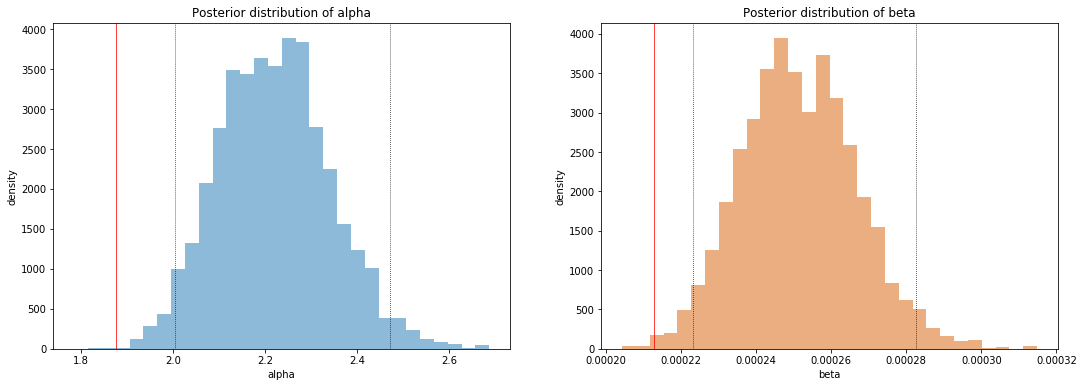

alpha 95%: [2.00378922 2.47047491]								beta 95%: [0.00022307 0.00028252]


In [12]:
# plotting posterior values on histograms

figsize(18,6)
# alpha hist
ax = plt.subplot(121)
_ = plt.title('Posterior distribution of alpha')
_ = plt.hist(alpha_samples, histtype='stepfilled', bins=30, alpha=0.5)
_ = plt.xlabel('alpha')
_ = plt.ylabel('density')
_ = plt.axvline(alpha_95[0], color='k', linestyle=':', linewidth=.75)
_ = plt.axvline(alpha_95[1], color='k', linestyle=':', linewidth=.75)
_ = plt.axvline(alpha_est, color='red', linewidth=.75)

# beta hist
ax = plt.subplot(122)
_ = plt.title('Posterior distribution of beta')
_ = plt.hist(beta_samples, histtype='stepfilled', bins=30, alpha=0.5, color="#d95f02")
_ = plt.xlabel('beta')
_ = plt.ylabel('density')
_ = plt.axvline(beta_95[0], color='k',  linestyle=':',linewidth=.75)
_ = plt.axvline(beta_95[1], color='k',  linestyle=':',linewidth=.75)
_ = plt.axvline(rate_est, color='red', linewidth=.75)

# show the plot
plt.show()

_ = print('alpha 95%: {}\t\t\t\t\t\t\t\tbeta 95%: {}'.format(alpha_95, beta_95))

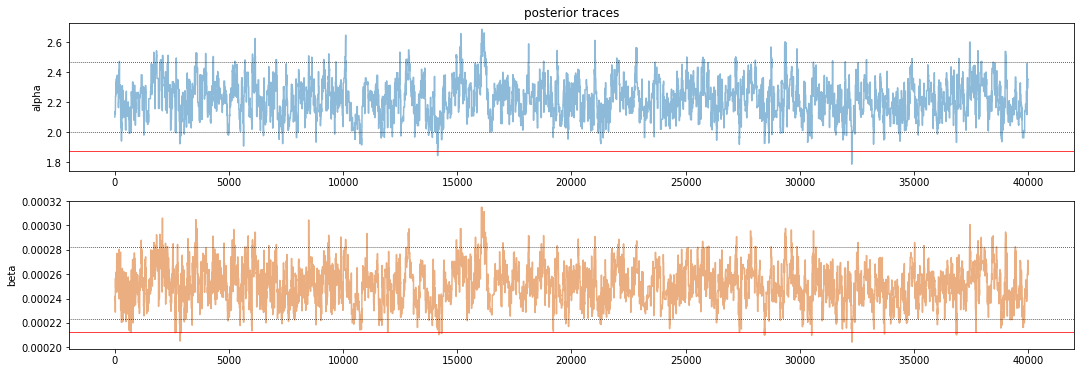

In [13]:
# plotting posterior traces on line plot

figsize(18,6)
# alpha line
ax = plt.subplot(211)
_ = plt.plot(alpha_samples, alpha=0.5)
_ = plt.ylabel('alpha')
_ = plt.axhline(alpha_95[0], color='k', linestyle=':', linewidth=.75)
_ = plt.axhline(alpha_95[1], color='k', linestyle=':', linewidth=.75)
_ = plt.axhline(alpha_est, color='red', linewidth=.75)
_ = plt.title('posterior traces')
# beta line
ax = plt.subplot(212)
_ = plt.plot(beta_samples, color="#d95f02", alpha=0.5)
_ = plt.ylabel('beta')
_ = plt.axhline(beta_95[0], color='k',  linestyle=':',linewidth=.75)
_ = plt.axhline(beta_95[1], color='k',  linestyle=':',linewidth=.75)
_ = plt.axhline(rate_est, color='red', linewidth=.75)

# show the plot
plt.show()

Histograms look good insofar as we can visibly identify values with higher confidence, and we capture our uncertainty about the distribution. 
    
Traces also reflect a visible distribution. 
    
A bad plot would not providing a strong indication for the value or have the highest distribution value not contained in the confidence interval.

__Q:__ Play around with some of the built-in diagnostic plots for your model. We suggest at least checking out the traceplot for alpha and beta. How do they look?

### Using PyMC3 Built-In Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D06EA07AC8>,
      dtype=object)

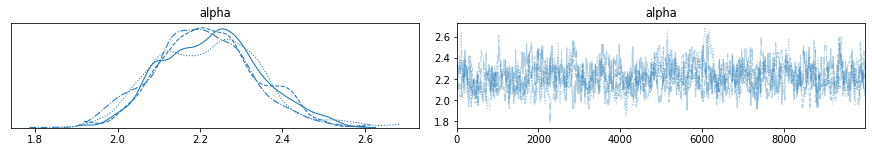

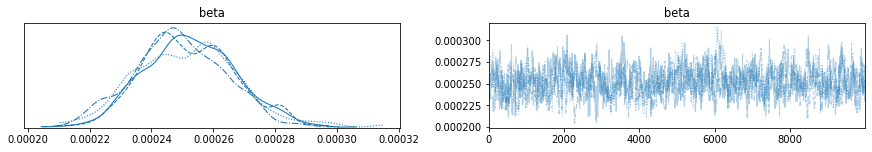

In [14]:
pm.plots.traceplot(trace, 'alpha')
pm.plots.traceplot(trace, 'beta')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D066F86DC8>],
      dtype=object)

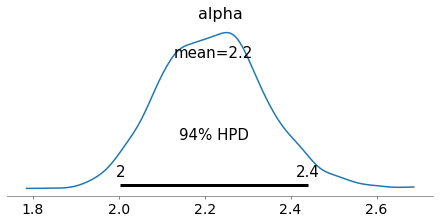

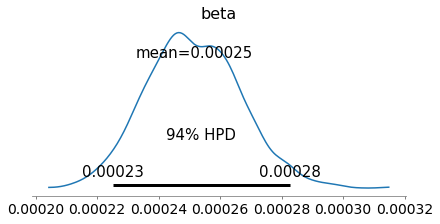

In [15]:
figsize(6,3)
pm.plots.plot_posterior(trace, "alpha")
pm.plots.plot_posterior(trace, "beta")

The built-in PyMC3 plots are very useful for quick observations. The line trace plot does a good job of autoscaling the y-axis on the mean value, and the density distribution plot on the left visibly captures where the highest points of tendency are located.    
    
The *plot_posterior* marks important statistics like the mean and the confidence interval on the plot itself, adding to the utility of the plot without having to write extra code to return those values.

### Applying Posteriors to New Simulation

In [16]:
alpha_est_2 = np.mean(alpha_samples)
beta_est_2 = 1/np.mean(beta_samples)

In [17]:
seed(47)
best_shot_simulated = gamma(alpha_est_2, scale=beta_est_2).rvs(n_no_ins)

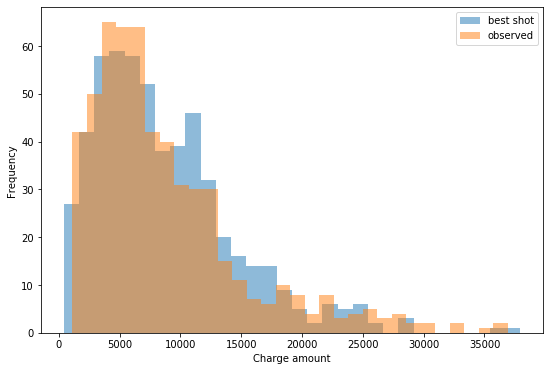

In [18]:
figsize(9,6)
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.5, label='best shot')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

## Summary

Above, we took the charges from no insurance from the data and modelled a gamma distribution with recommended guesses for the alpha and beta (We used 'rate = 1/beta' form of the parameters in this notebook). 
    
From this, we decided to use PyMC3 to perform Bayesian inference to see if our posterior outcomes can better define a model that fits our data.

Finally, we use the mean parameter values from the PyMC3 test to create another simulated distribution of random variates and overlay it against our observed values to confirm that our posteriors are still relative to the data.